Аналіз датасету abalone

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style='darkgrid', palette='deep')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,classification_report
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import Counter
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

path = "/content/drive/MyDrive/ML_Hillel/HW_L7_Imbalance_kNN/abalone/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Зчитуємо датасет (abalone):
df_columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv(path + 'abalone.data', delimiter=',', names = df_columns)
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
# Подивимось інформацію по колонках:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Бачимо, що є одна категорійна колонка (Sex), решта - числові, пропусків немає. Таргет - Rings

1. Операції з Sex


Оскільки ця колонка категорійна, то перетворимо її в числову

In [6]:
df['Sex'].value_counts()

,count
Sex,
M,1528
I,1342
F,1307


Змінна набуває 3 значень, перекодуємо в числові через OneHotEncoder, додавши 2 колонки.


<Axes: xlabel='Sex', ylabel='count'>

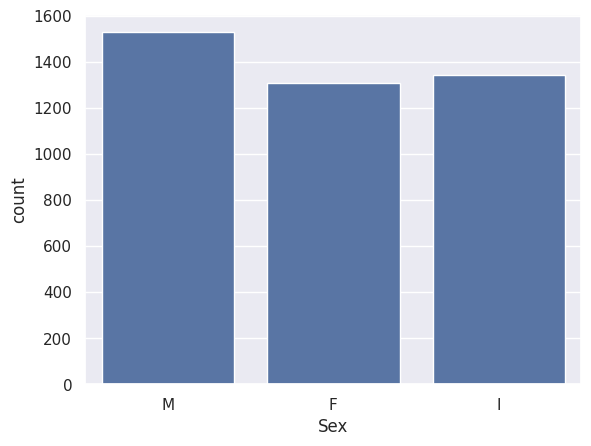

In [7]:
# Виведемо графік розподілу змінної:
sns.countplot(data=df, x='Sex')

Ілюстрація розподілу змінної (дані набувають 3 різних значень і приблизно однаково розподілені)

In [8]:

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df[['Sex_F', 'Sex_I', 'Sex_M']] = enc.fit_transform(df[['Sex']])
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,0.0,1.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,0.0,1.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1.0,0.0,0.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,0.0,1.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.0,1.0,0.0


<Axes: xlabel='Rings', ylabel='count'>

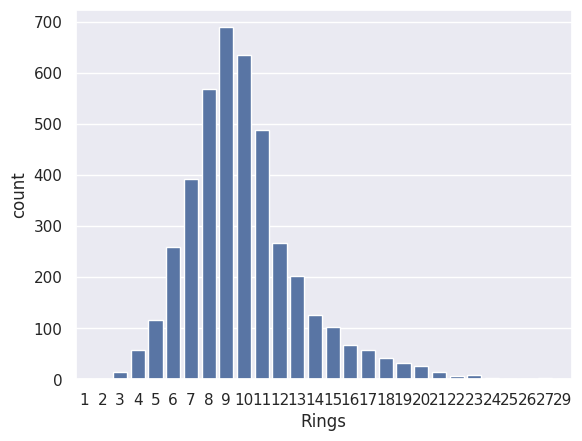

In [9]:
# Виведемо графік розподілу таргет змінної:
sns.countplot(data=df, x='Rings')

Найчастіше зустрічаються особини з 9 (або біля 9) кільцями. Графік трохи скошений в праву сторону

In [10]:
#Видаляємо колонку Sex
df = df.drop(['Sex'], axis = 1)
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.0,1.0,0.0


In [11]:
# Виведемо описову статистику датасету
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.312904,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.463731,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


Найменше значення цільової змінної - 1, найбільше - 29. Але крайні значення зустрічаються дуже рідко, 50% вибірки має від 8 до 11 кілець

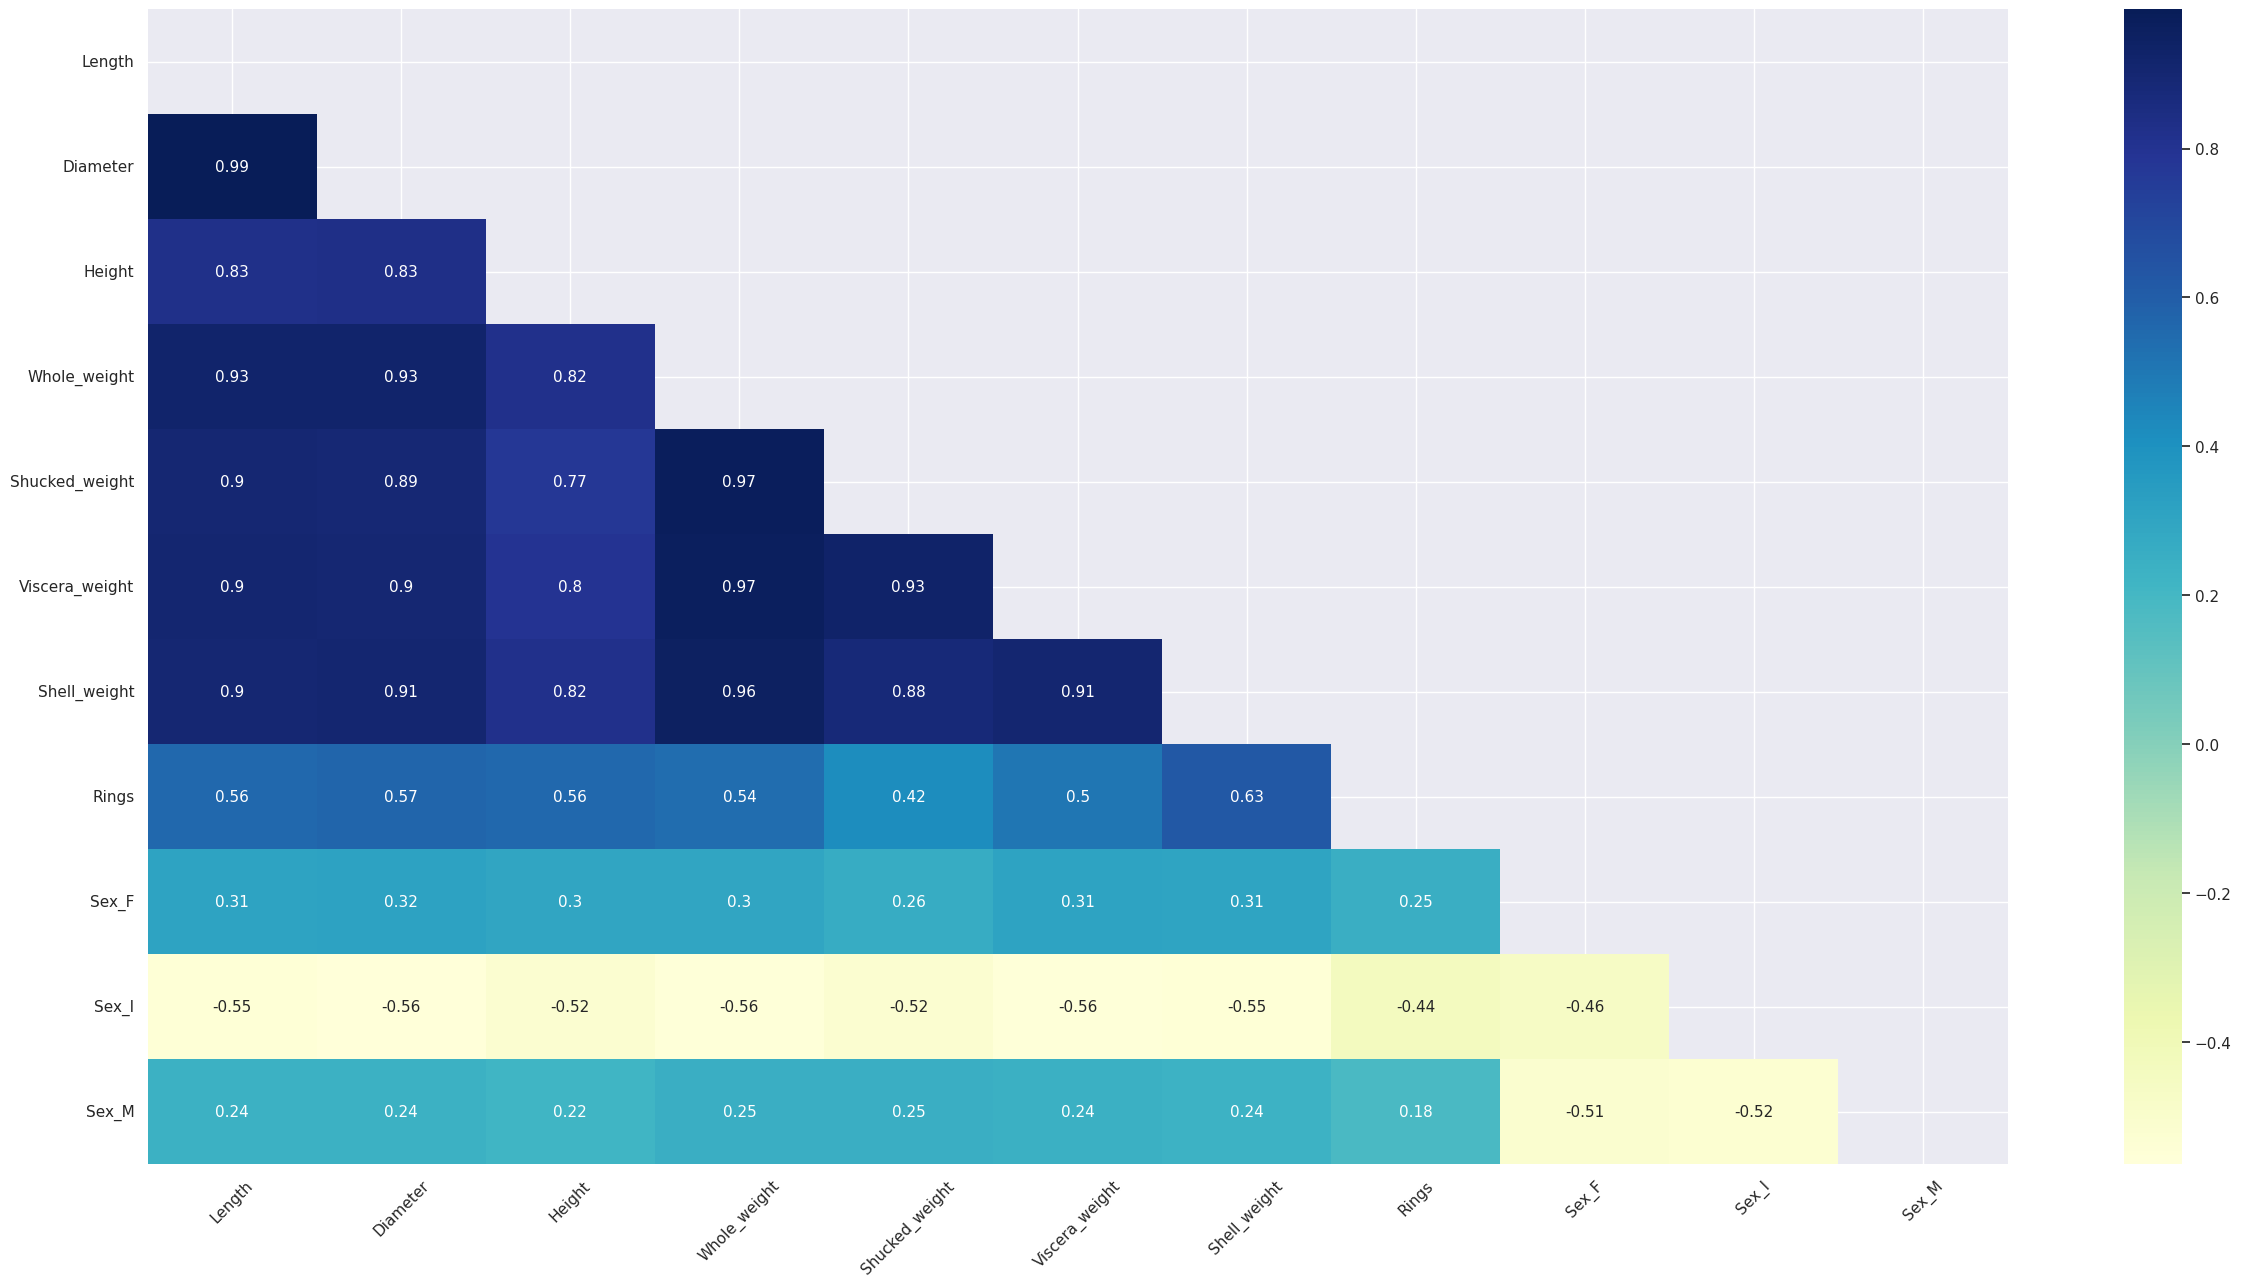

In [12]:
# Побудуємо матрицю кореляцій для першого датасету за допомогою heatmap:
corr_matrix = df.corr()

plt.figure(figsize=(30, 15))

# Для зручності сприйняття створимо маску для правої верхньої частини матриці:
mask = np.triu(corr_matrix)

# Створимо теплову карту з врахуванням маски:
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

Багато фіч мають значний взаємозв'язок:
1) Length i Diameter мають кореляцію 0.99, крім того, обидва параметри значно корелюють з параметрами ваг

2) змінна Whole_weight значно корелює (r > 0.9) із параметрами Shucked_weight,	Viscera_weight,	Shell_weight, що є зрозуміло судячи з назви Whole weight (Shucked_weight,	Viscera_weight,	Shell_weight є просто додатками у змінній загальної ваги).

Тому для аналізу залишимо тільки параметр Whole weight, відкинувши мультиколінеарні з нею фічі.

In [13]:
#Видаляємо мультиколінеарні колонки
df = df.drop(['Length', 'Diameter', 'Shucked_weight', 'Viscera_weight', 'Shell_weight'], axis = 1)
df.head()

,Height,Whole_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.095,0.5140,15,0.0,0.0,1.0
1,0.090,0.2255,7,0.0,0.0,1.0
2,0.135,0.6770,9,1.0,0.0,0.0
3,0.125,0.5160,10,0.0,0.0,1.0
4,0.080,0.2050,7,0.0,1.0,0.0


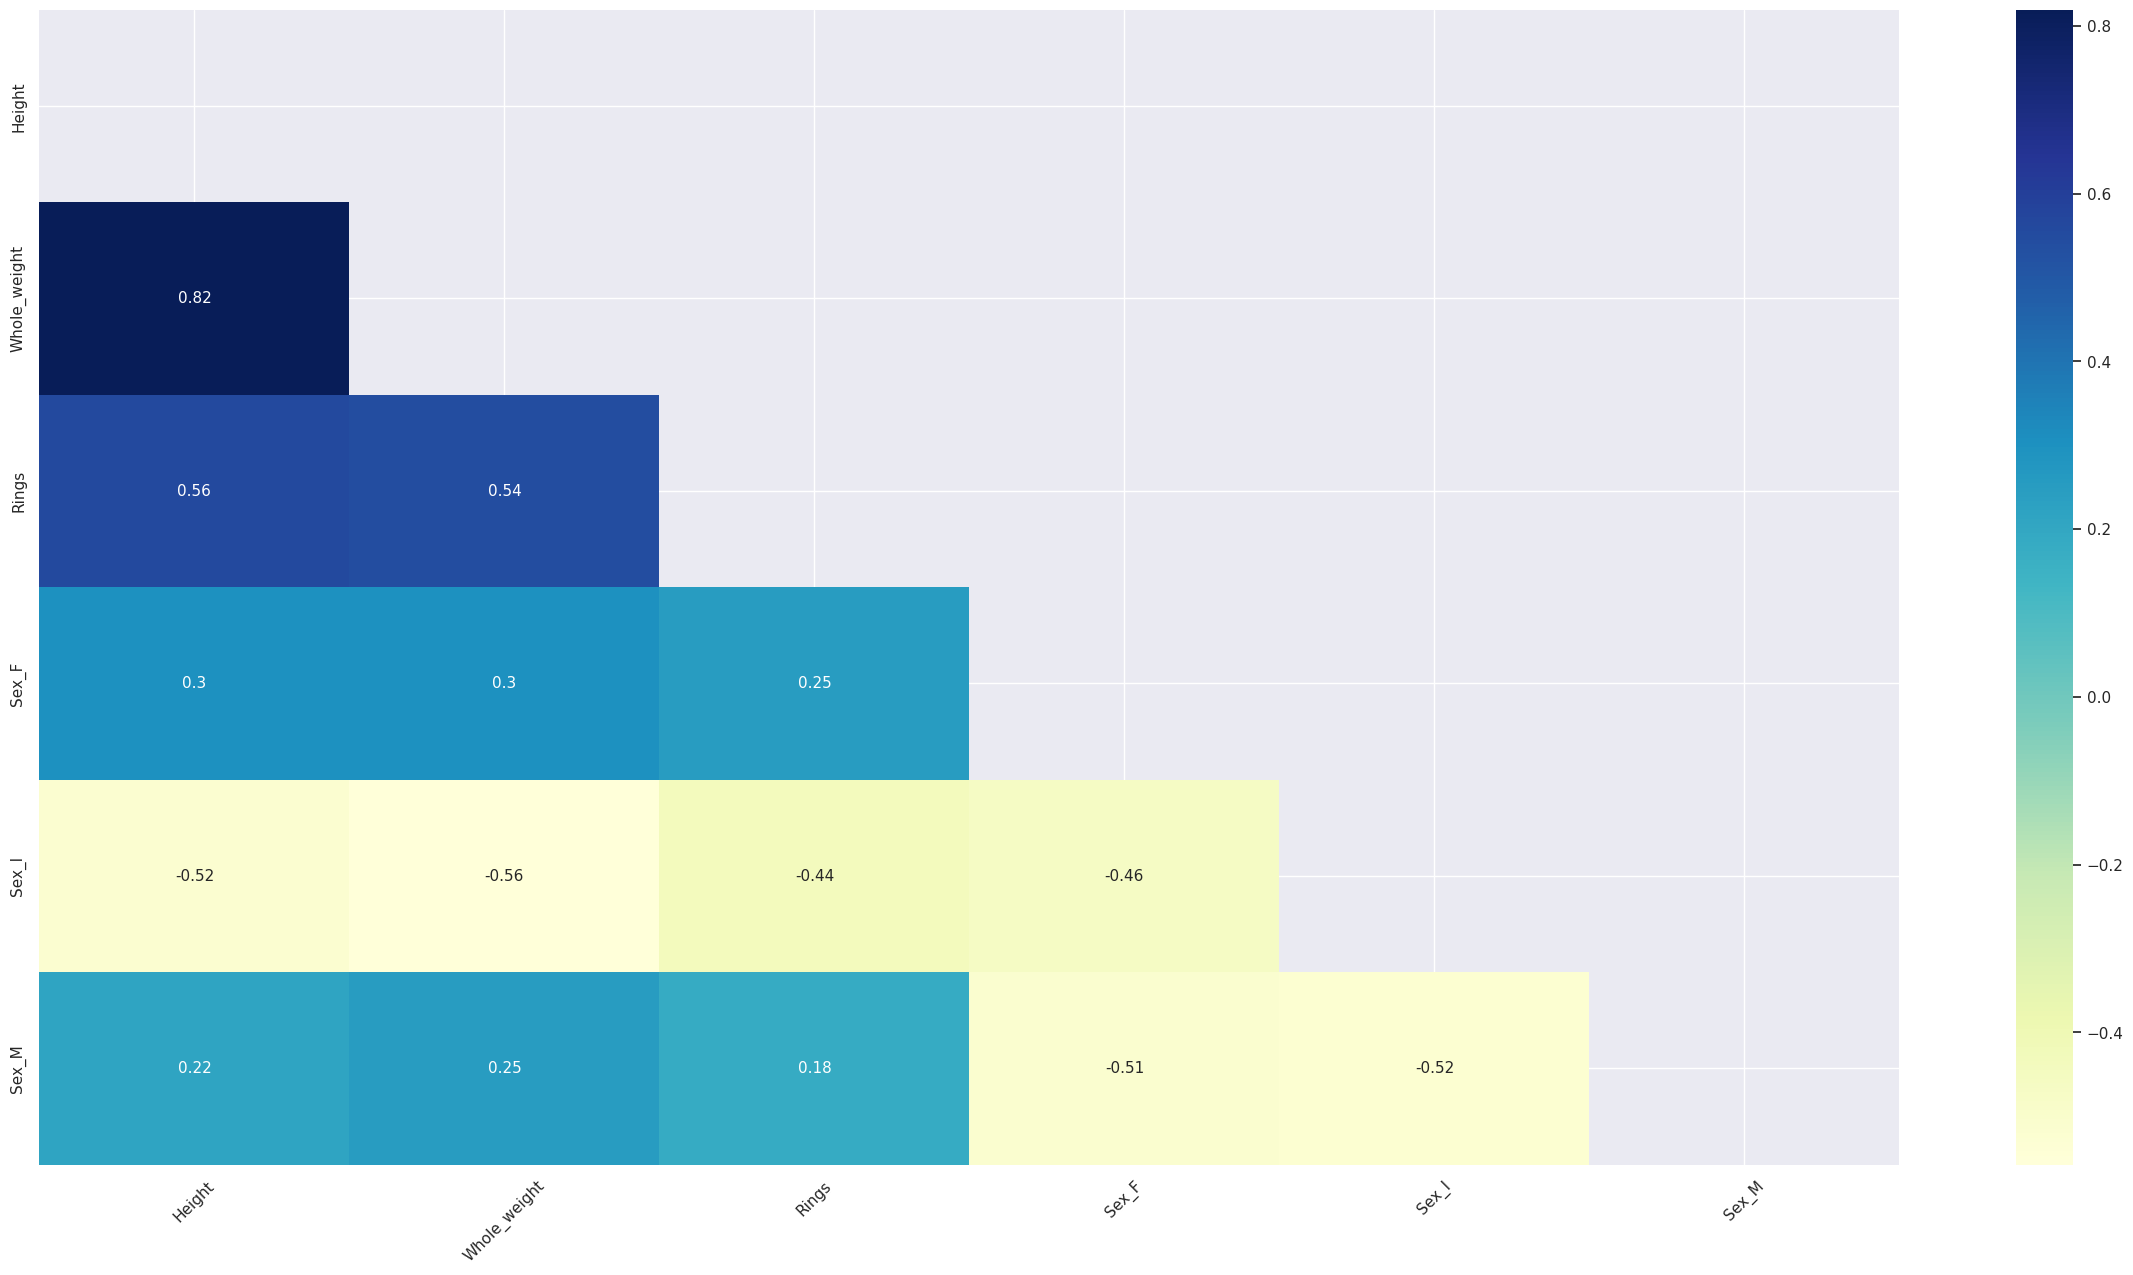

In [14]:
# Побудуємо матрицю кореляцій для першого датасету за допомогою heatmap:
corr_matrix = df.corr()

plt.figure(figsize=(30, 15))

# Для зручності сприйняття створимо маску для правої верхньої частини матриці:
mask = np.triu(corr_matrix)

# Створимо теплову карту з врахуванням маски:
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

Бачимо відносно високу кореляцію ($r_{xy}=0.82$) між  змінними Height i Whole_weight, оціними модель з двома цими параметрами, і потім з одним, і порівняємо оцінки

In [15]:
#Стандартизація значень
df_columns_scaled = list(df.columns)
df_columns_scaled.remove('Rings')
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df.drop(columns='Rings')), columns = df_columns_scaled)
X = df_scaled.copy()
y = df['Rings']
df_scaled['Rings'] = df['Rings']
df_scaled


,Height,Whole_weight,Sex_F,Sex_I,Sex_M,Rings
0,-1.064424,-0.641898,-0.674834,-0.688018,1.316677,15
1,-1.183978,-1.230277,-0.674834,-0.688018,1.316677,7
2,-0.107991,-0.309469,1.481846,-0.688018,-0.759488,9
3,-0.347099,-0.637819,-0.674834,-0.688018,1.316677,10
4,-1.423087,-1.272086,-0.674834,1.453451,-0.759488,7
...,...,...,...,...,...,...
4172,0.609334,0.118813,1.481846,-0.688018,-0.759488,11
4173,-0.107991,0.279929,-0.674834,-0.688018,1.316677,10
4174,1.565767,0.708212,-0.674834,-0.688018,1.316677,9
4175,0.250672,0.541998,1.481846,-0.688018,-0.759488,10


In [16]:
X

,Height,Whole_weight,Sex_F,Sex_I,Sex_M
0,-1.064424,-0.641898,-0.674834,-0.688018,1.316677
1,-1.183978,-1.230277,-0.674834,-0.688018,1.316677
2,-0.107991,-0.309469,1.481846,-0.688018,-0.759488
3,-0.347099,-0.637819,-0.674834,-0.688018,1.316677
4,-1.423087,-1.272086,-0.674834,1.453451,-0.759488
...,...,...,...,...,...
4172,0.609334,0.118813,1.481846,-0.688018,-0.759488
4173,-0.107991,0.279929,-0.674834,-0.688018,1.316677
4174,1.565767,0.708212,-0.674834,-0.688018,1.316677
4175,0.250672,0.541998,1.481846,-0.688018,-0.759488


#KNN Regression

In [17]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [18]:
# Створюємо об'єкт KNeighborsRegressor:
knn_reg = KNeighborsRegressor(n_neighbors=5, weights = 'uniform')

# Робимо крос-валідацію с кількістю фолдів = 5:
cv_scores = cross_val_score(knn_reg, X_train, y_train, cv=5)

# Тренуємо модель на тренувальних даних:
knn_reg.fit(X_train, y_train)

# Розраховуємо оцінку на треувальній та тестовій вибірці:
train_score = knn_reg.score(X_train, y_train)
test_score = knn_reg.score(X_test, y_test)

# Виводимо на екран оцінку по фолдам а також по тренувальній та тестовій вибіркам:
print("Cross-Validation Scores:", cv_scores)
print("Train Score:", train_score)
print("Test Score:", test_score)

y_pred = knn_reg.predict(X_test)
print('R2:', r2_score(y_test, y_pred))

Cross-Validation Scores: [0.27701731 0.32179498 0.32292142 0.28275308 0.27046329]
Train Score: 0.5258213268319235
Test Score: 0.2713582784615086
R2: 0.2713582784615086


In [19]:
# Знайдемо метрики моделі MSE та RMSE.

def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    return {
        "MSE Train": round(mse_train, 3),
        "MSE Test": round(mse_test, 3),
        "RMSE Train": round(rmse_train, 3),
        "RMSE Test": round(rmse_test, 3)
    }

Для базової моделі kNN коефіцієнт детермінації = 0,27

In [20]:
# Обчислюємо метрики для моделі
evaluate_model(knn_reg, X_train, X_test, y_train, y_test)

{'MSE Train': 4.849,
 'MSE Test': 7.933,
 'RMSE Train': 2.202,
 'RMSE Test': 2.817}

...і MSE на тесті = 7.9

Спробуємо підвищити характеристики моделі шляхом підбору гіперпараметрів з використанням GridSearchCV

In [21]:
#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(4, 10), 'p': range(1, 4),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [22]:
y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)

evaluate_model(knn_grid, X_train, X_test, y_train, y_test)

MSE: 7.534573808258019
MAE: 1.9695906432748538
R2: 0.30798481029897284
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 3, 'weights': 'uniform'}


{'MSE Train': 5.398,
 'MSE Test': 7.535,
 'RMSE Train': 2.323,
 'RMSE Test': 2.745}

За результатами підбору характеристики моделі трохи покращилися - R2 зріс до
0.3, MSE знизилось до 7.53

Оптимальними виявилися параметри n_neighbors=9, і кубічна метрика Мінковського (p=3), решта значень дефолтні

Тепер проведемо аналіз для датасету без значення "Whole weight"

In [23]:
X_4col_h = X.drop(['Whole_weight'], axis = 1) #видаляємо відповідну фічу

In [24]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_4col_h, y, test_size=0.25, random_state=17)

In [25]:
#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(4, 10), 'p': range(1, 4),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [26]:
y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)

evaluate_model(knn_grid, X_train, X_test, y_train, y_test)

MSE: 7.25196999232087
MAE: 1.945879851143009
R2: 0.3339406424764527
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 3, 'weights': 'uniform'}


{'MSE Train': 6.376,
 'MSE Test': 7.252,
 'RMSE Train': 2.525,
 'RMSE Test': 2.693}

Висновок: без врахування загальної ваги вдалось підвищити характеристику моделі R2 до 0.33. Тому виходить, що краще з параметрів висоти та ваги для моделі враховувати тільки одну змінну.

Зворотній підхід: залишити тільки Whole weight та ознаки статі

In [27]:
X_4col_w = X.drop(['Height'], axis = 1) #видаляємо відповідну фічу

In [28]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_4col_w, y, test_size=0.25, random_state=17)

In [29]:
#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(4, 10), 'p': range(1, 4),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [30]:
y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)
evaluate_model(knn_grid, X_train, X_test, y_train, y_test)

MSE: 7.568846358320043
MAE: 1.9967038809144073
R2: 0.3048370376662707
{'algorithm': 'brute', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


{'MSE Train': 5.741,
 'MSE Test': 7.569,
 'RMSE Train': 2.396,
 'RMSE Test': 2.751}

Бачимо, що краще використовувати змінну Height

Ще спробуємо порівняти модель з середнім змінних Height та Whole_weight

In [31]:
X['Av_H_W'] = (X['Height'] + X['Whole_weight'])/2 #Введемо нову фічу на основі висоти і загальної ваги, як просте арифметичне середнє
X_4col_av_hw = X.drop(['Height', 'Whole_weight'], axis = 1) #видаляємо відповідні фічі
X_4col_av_hw

,Sex_F,Sex_I,Sex_M,Av_H_W
0,-0.674834,-0.688018,1.316677,-0.853161
1,-0.674834,-0.688018,1.316677,-1.207128
2,1.481846,-0.688018,-0.759488,-0.208730
3,-0.674834,-0.688018,1.316677,-0.492459
4,-0.674834,1.453451,-0.759488,-1.347586
...,...,...,...,...
4172,1.481846,-0.688018,-0.759488,0.364074
4173,-0.674834,-0.688018,1.316677,0.085969
4174,-0.674834,-0.688018,1.316677,1.136990
4175,1.481846,-0.688018,-0.759488,0.396335


In [32]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_4col_av_hw, y, test_size=0.25, random_state=17)

In [33]:
#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(4, 10), 'p': range(1, 4),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [34]:
y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)

evaluate_model(knn_grid, X_train, X_test, y_train, y_test)

MSE: 7.672337409179515
MAE: 2.0058479532163744
R2: 0.2953318710814822
{'algorithm': 'brute', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


{'MSE Train': 5.536, 'MSE Test': 7.672, 'RMSE Train': 2.353, 'RMSE Test': 2.77}

Кращого результату не досягнуто, тому висновок: у тих експериментах найкращим було рішення моделі з використанням висоти та ознак статі, яке давало найкращі характеристики. Це можна пояснити, оскільки в середньому чим більша висота тварини, ти більше буде її вага.

Ще побудуємо просту модель, в якій незалежною змінною буде лише висота.

In [35]:
X_only_h = X[['Height']] #Матриця з однієї фічі
X_only_h

,Height
0,-1.064424
1,-1.183978
2,-0.107991
3,-0.347099
4,-1.423087
...,...
4172,0.609334
4173,-0.107991
4174,1.565767
4175,0.250672


In [36]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_only_h, y, test_size=0.25, random_state=17)

In [37]:
#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(4, 10), 'p': range(1, 4),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [38]:
y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)

evaluate_model(knn_grid, X_train, X_test, y_train, y_test)

MSE: 7.408687852236932
MAE: 2.0091140507239578
R2: 0.3195468436605876
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


{'MSE Train': 7.016,
 'MSE Test': 7.409,
 'RMSE Train': 2.649,
 'RMSE Test': 2.722}

Як бачимо, характеристики моделі дещо погіршились, тому значення статі особин таки мають певний взаємозв'язок із кількістю кілець. Це теж загалом є очевидним, оскільки кількість кілець характеризує вік, тип infant - означає дитячий вік. Також виявлено (згідно матриці кореляцій), що в середньому особини статі Female живуть довше, ніж статі Male.

###Модель без викидів.
Побудуємо модель на основі змінних висоти і статі без врахування викидів

In [39]:
#Сформуємо датасет з цільовою змінною
df_h_sex = pd.concat([X_4col_h, df['Rings']], axis = 1)
df_h_sex

,Height,Sex_F,Sex_I,Sex_M,Rings
0,-1.064424,-0.674834,-0.688018,1.316677,15
1,-1.183978,-0.674834,-0.688018,1.316677,7
2,-0.107991,1.481846,-0.688018,-0.759488,9
3,-0.347099,-0.674834,-0.688018,1.316677,10
4,-1.423087,-0.674834,1.453451,-0.759488,7
...,...,...,...,...,...
4172,0.609334,1.481846,-0.688018,-0.759488,11
4173,-0.107991,-0.674834,-0.688018,1.316677,10
4174,1.565767,-0.674834,-0.688018,1.316677,9
4175,0.250672,1.481846,-0.688018,-0.759488,10


In [40]:
df_h_sex.columns[:-1]

Index(['Height', 'Sex_F', 'Sex_I', 'Sex_M'], dtype='object')

In [41]:
#Аналіз викидів: видалення викидів для колонки  Height
df_h_sex_dropped_outlayers = df_h_sex.copy()  #Формуємо копію DF для проведення аналізу
desc = df_h_sex_dropped_outlayers.describe()
IQR = desc['Height']['75%'] - desc['Height']['25%']
df_h_sex_dropped_outlayers.drop(df_h_sex_dropped_outlayers[(df_h_sex_dropped_outlayers['Height'] < desc['Height']['25%'] - 1.5 * IQR) | (df_h_sex_dropped_outlayers['Height'] > desc['Height']['75%'] + 1.5 * IQR)].index, inplace = True)

# Видалено значення викидів для всіх колонок, залишилось 80% початкового датасету (по об'єктах)
df_h_sex_dropped_outlayers.shape

(4148, 5)

In [42]:
df_h_sex_dropped_outlayers = df_h_sex_dropped_outlayers.reset_index(drop=True) #впорядкуємо індекси після видалення рядків
X_h_sex_dropped_outlayers = df_h_sex_dropped_outlayers.drop(columns='Rings')
y_h_sex_dropped_outlayers = df_h_sex_dropped_outlayers['Rings']
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_h_sex_dropped_outlayers, y_h_sex_dropped_outlayers, test_size=0.25, random_state=17)

#GridSearchCV

param_grid = {'n_neighbors': range(4, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_r = KNeighborsRegressor()

knn_grid = GridSearchCV(estimator=knn_r,
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=5)
knn_grid.fit(X_train, y_train)


y_pred = knn_grid.predict(X_test)
best_model = knn_grid.best_params_

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

print(best_model)

evaluate_model(knn_grid, X_train, X_test, y_train, y_test)


MSE: 6.894627189066276
MAE: 1.9132111861137897
R2: 0.31507812430216886
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


{'MSE Train': 6.55, 'MSE Test': 6.895, 'RMSE Train': 2.559, 'RMSE Test': 2.626}

Видалення викидів по висоті не допомогло покращити якість моделі, викиди не впливають негативно на саму модель.

#KNN Classification

In [43]:
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)


In [44]:
# Створимо функцію, яка буде виводити репорти:
def get_report(model, X, y_true):
    y_pred = model.predict(X)
    print(classification_report(y_true, y_pred, digits=3))

In [45]:
# Навчимо та застосуємо kNN класифікацію, а також виведемо репорт:

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print('KNeighbors Classification, train data:')
get_report(knn_clf, X_train, y_train)

print('KNeighbors Classification, test data:')
get_report(knn_clf, X_test, y_test)


#Прогнозування моделі
y_pred = knn_clf.predict(X_test)



KNeighbors Classification, train data:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.474     0.750     0.581        12
           4      0.517     0.625     0.566        48
           5      0.427     0.609     0.502        92
           6      0.466     0.571     0.514       182
           7      0.427     0.482     0.453       284
           8      0.415     0.572     0.481       423
           9      0.423     0.546     0.477       520
          10      0.438     0.520     0.475       485
          11      0.451     0.377     0.411       369
          12      0.373     0.192     0.253       198
          13      0.475     0.185     0.267       151
          14      0.409     0.176     0.247       102
          15      0.476     0.120     0.192        83
          16      0.455     0.102     0.167        49
          17      0.667     0.050     0.093        40
          18      0.000     0.000     0.00

Бачимо, що для значень, які трапляються  часто в датасеті f1 в районі 20-30%,
але для значень, які рідко трапляються, модель гірше визначає їх, оскільки не може натренуватися.

Text(249.2500000000001, 0.5, 'true label')

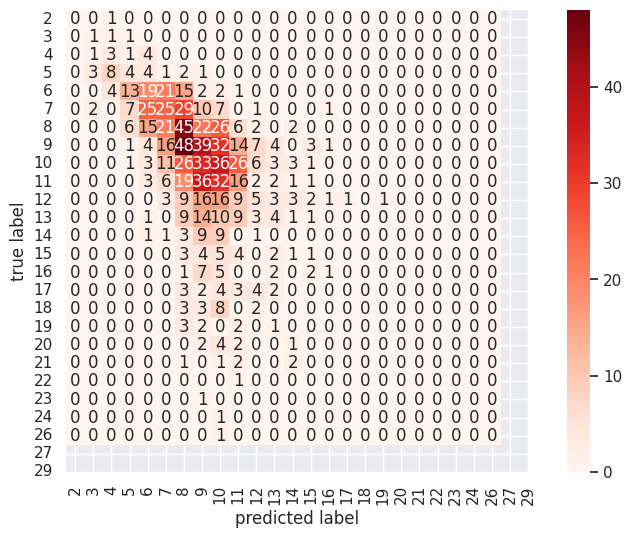

In [46]:
# Давайте для наглядності побудуємо confusion matrix:

labels = knn_clf.classes_
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')

In [47]:
y.value_counts()

,count
Rings,
9,689
10,634
8,568
11,487
7,391
12,267
6,259
13,203
14,126


Видалимо явно нетипові значення таргету для моделі, які трапляються 1-2 рази

In [58]:
df_scaled_clf = df_scaled[(df_scaled['Rings'] > 2) & (df_scaled['Rings'] < 24)]
X = df_scaled_clf.copy().iloc[:, :-1]
y = df_scaled_clf['Rings']

# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

# Навчимо та застосуємо kNN класифікацію, а також виведемо репорт:

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print('KNeighbors Classification, train data:')
get_report(knn_clf, X_train, y_train)

print('KNeighbors Classification, test data:')
get_report(knn_clf, X_test, y_test)


#Прогнозування моделі
y_pred = knn_clf.predict(X_test)

KNeighbors Classification, train data:
              precision    recall  f1-score   support

           3      0.500     0.583     0.538        12
           4      0.492     0.682     0.571        44
           5      0.484     0.500     0.492        90
           6      0.420     0.598     0.494       194
           7      0.395     0.476     0.432       292
           8      0.415     0.540     0.470       435
           9      0.428     0.551     0.482       537
          10      0.424     0.453     0.438       466
          11      0.477     0.412     0.442       352
          12      0.466     0.246     0.322       195
          13      0.423     0.220     0.289       150
          14      0.382     0.130     0.194       100
          15      0.562     0.117     0.194        77
          16      0.375     0.125     0.188        48
          17      0.571     0.105     0.178        38
          18      0.667     0.200     0.308        30
          19      0.250     0.037     0.06

Бачимо, що f1 дещо зріс, але є ознаки перенавченості моделі

Видалимо фічу Whole_weight, яка має значну кореляцію з Height

In [94]:
X_h = X.drop(['Whole_weight'], axis = 1) #видаляємо фічу Whole_weight
# Ділимо вибірку на трейнову та тестову
X_train, X_test, y_train, y_test = train_test_split(X_h, y, test_size=0.25, random_state=17)

# Навчимо та застосуємо kNN класифікацію, а також виведемо репорт:

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print('KNeighbors Classification, train data:')
get_report(knn_clf, X_train, y_train)

print('KNeighbors Classification, test data:')
get_report(knn_clf, X_test, y_test)


#Прогнозування моделі
y_pred = knn_clf.predict(X_test)

KNeighbors Classification, train data:
              precision    recall  f1-score   support

           3      0.500     0.500     0.500        12
           4      0.390     0.523     0.447        44
           5      0.378     0.344     0.360        90
           6      0.239     0.268     0.252       194
           7      0.249     0.315     0.278       292
           8      0.240     0.372     0.292       435
           9      0.247     0.266     0.256       537
          10      0.217     0.236     0.226       466
          11      0.234     0.224     0.229       352
          12      0.117     0.046     0.066       195
          13      0.106     0.093     0.099       150
          14      0.194     0.120     0.148       100
          15      0.667     0.026     0.050        77
          16      0.333     0.042     0.074        48
          17      0.500     0.053     0.095        38
          18      0.000     0.000     0.000        30
          19      0.000     0.000     0.00

Як бачимо, результат не змінився

Тепер підберемо гіперпараметри для моделі, використовуючи GridSearchCV

In [95]:
#GridSearchCV
# Навчимо та застосуємо kNN класифікацію з оптимальними параметрами, а також виведемо репорт:
param_grid = {'n_neighbors': range(4, 50),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': range(1,4)}

knn_c = KNeighborsClassifier()

knn_grid_c = GridSearchCV(estimator=knn_c,
                                 param_grid=param_grid,
                                 scoring='f1_macro',
                                 cv=5)
knn_grid_c.fit(X_train, y_train)

y_pred = knn_grid_c.predict(X_test)
best_model = knn_grid_c.best_params_
print(best_model)



{'algorithm': 'auto', 'n_neighbors': 48, 'p': 1, 'weights': 'distance'}


In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       0.46      0.46      0.46        13
           5       0.32      0.24      0.27        25
           6       0.25      0.20      0.22        65
           7       0.31      0.36      0.33        99
           8       0.25      0.35      0.29       133
           9       0.19      0.32      0.24       152
          10       0.24      0.29      0.26       168
          11       0.16      0.21      0.18       135
          12       0.12      0.01      0.03        72
          13       0.12      0.02      0.03        53
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        26
          16       0.00      0.00      0.00        19
          17       0.00      0.00      0.00        20
          18       0.00      0.00      0.00        12
          19       0.00      0.00      0.00         5
          20       0.00    

Найкращими параметрами виявились 'n_neighbors': 48, метрика L1, ваги на основі відстані ('weights': 'distance'), за яких показники моделі трохи зросли

Наостанку проведемо збалансовування даних (Oversampling) з використанням алгоритму RandomOverSampler

In [97]:
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X_h, y, test_size=0.25, random_state=17)
ros = RandomOverSampler(random_state=17)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_resampled).items()))

[(3, 15), (4, 57), (5, 115), (6, 259), (7, 391), (8, 568), (9, 689), (10, 634), (11, 487), (12, 267), (13, 203), (14, 126), (15, 103), (16, 67), (17, 58), (18, 42), (19, 32), (20, 26), (21, 14), (22, 6), (23, 9)]
[(3, 537), (4, 537), (5, 537), (6, 537), (7, 537), (8, 537), (9, 537), (10, 537), (11, 537), (12, 537), (13, 537), (14, 537), (15, 537), (16, 537), (17, 537), (18, 537), (19, 537), (20, 537), (21, 537), (22, 537), (23, 537)]


In [99]:
knn_balanced = KNeighborsClassifier(n_neighbors=48, p=16, weights='distance')
knn_balanced.fit(X_resampled, y_resampled)

#Прогнозування моделі
y_pred = knn_balanced.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.11      0.67      0.18         3
           4       0.14      0.54      0.22        13
           5       0.24      0.16      0.19        25
           6       0.22      0.11      0.14        65
           7       0.31      0.30      0.30        99
           8       0.23      0.35      0.27       133
           9       0.17      0.20      0.19       152
          10       0.23      0.24      0.24       168
          11       0.14      0.12      0.13       135
          12       0.09      0.03      0.04        72
          13       0.26      0.09      0.14        53
          14       0.09      0.12      0.10        26
          15       0.05      0.08      0.06        26
          16       0.00      0.00      0.00        19
          17       0.00      0.00      0.00        20
          18       0.00      0.00      0.00        12
          19       0.00      0.00      0.00         5
          20       0.00    

Як бачимо, що збалансовування не дуже покращило модель. Однією з основних причин цього є дуже велика кількість класів, для такої кількості краще застосовувати регресію.
Подальшими кроками для оптимізації класифікаційних моделей може бути групування таргет змінної на кілька категорій з метою зменшення кількості класів.